
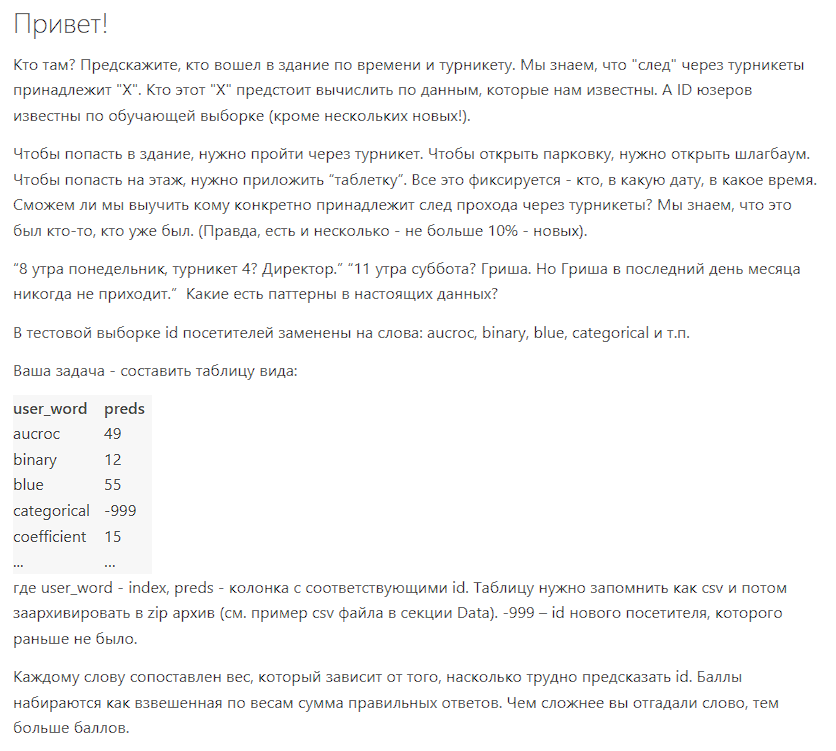

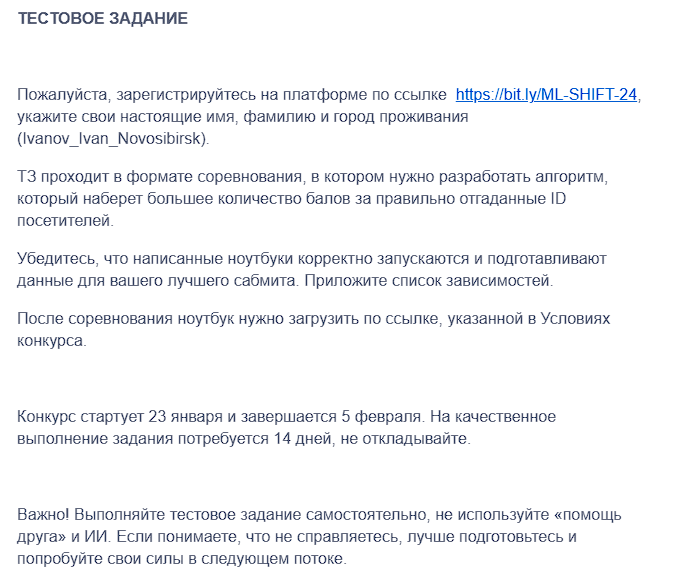

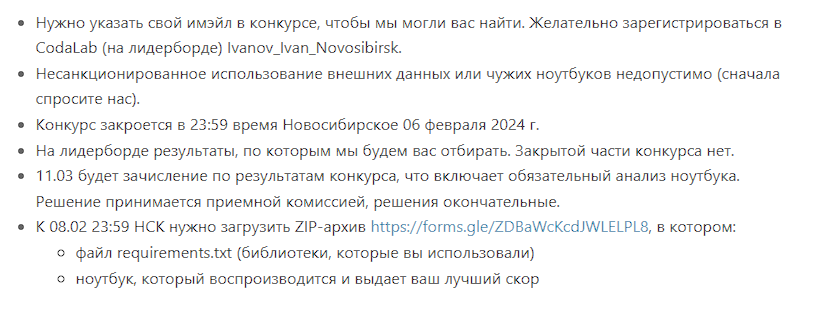

Импорт необходимых библиотек

In [96]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_regression, chi2
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline as imb_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

Зашрузка данных и их первичный анализ

In [2]:
# загрузка данных
submit = pd.read_csv('submit.csv')
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

In [3]:
# функция для проврки пропусков
def pass_value_barh(df):
    """
    Функция для наглядного представления пропусков в данных
    """
    try:
        (
            (df.isna().sum())
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), rot = -5, legend = False, fontsize = 16)
            .set_title('Пример' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось ')
checklist = ['submit', 'test', 'train']
for name in checklist:
    pass_value_barh(name)

пропусков не осталось 
пропусков не осталось 
пропусков не осталось 


Выведем информацию о данных

In [4]:
# общая информация о данных
print(submit.info(), end = '\n')
print(test.info(), end = '\n')
print(train.info(), end = '\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_word  34 non-null     object
 1   preds      34 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 672.0+ bytes
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7125 entries, 0 to 7124
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  7125 non-null   int64 
 1   ts          7125 non-null   object
 2   gate_id     7125 non-null   int64 
 3   user_word   7125 non-null   object
dtypes: int64(2), object(2)
memory usage: 222.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37518 entries, 0 to 37517
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  37518 non-null  int64 
 1   user_id     37518 non-null  int64 
 2   ts    

In [5]:
# проврка на дубликаты 
print('Количество дубликатов в "data_1": ', test.duplicated().sum())
print('Количество дубликатов в "data_2": ', train.duplicated().sum())

Количество дубликатов в "data_1":  0
Количество дубликатов в "data_2":  0


Посмотрим на распределение целевого признака в train

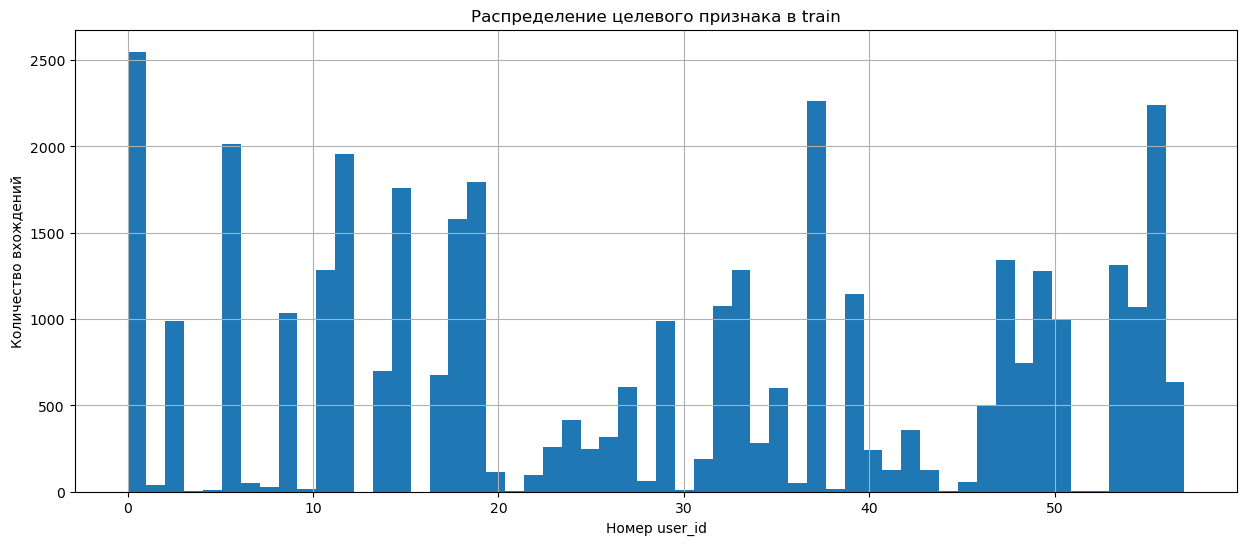

In [6]:
# график распределения
train.user_id.hist(bins=train.user_id.nunique(), figsize = (15, 6))
plt.title('Распределение целевого признака в train')
plt.xlabel('Номер user_id')
plt.ylabel('Количество вхождений')
plt.show()

In [7]:
# изменение формата данных
train['ts'] = pd.to_datetime(train['ts'], format = '%Y-%m-%d %H:%M:%S')
test['ts'] = pd.to_datetime(test['ts'], format = '%Y-%m-%d %H:%M:%S')

Необходимо проверить все ли gate_id присутствуют в train и test

In [8]:
# проверка и вывод недостающих
if sorted(list(train['gate_id'].unique())) != sorted(list(test['gate_id'].unique())):
    train_list = list(train['gate_id'].unique())
    test_list = list(test['gate_id'].unique())  
    print('Пропущенные gate_id', [x for x in train_list if x not in test_list] + [x for x in test_list if x not in train_list])
else:
    print('gate_id в train и test идентичны')

Пропущенные gate_id [0, 16, 2]


In [9]:
# посмотрим колшичество вхоэжений gate_id в train
train['gate_id'].value_counts().sort_index()

-1       48
 0        2
 1        5
 3     5351
 4     8170
 5     4619
 6     1800
 7     3026
 8       48
 9     3390
 10    4767
 11    4090
 12     698
 13    1201
 14       1
 15     298
 16       4
Name: gate_id, dtype: int64

In [10]:
# посмотрим колшичество вхоэжений gate_id в test
test['gate_id'].value_counts().sort_index()

-1        2
 1        2
 2        4
 3      909
 4     1459
 5      860
 6      294
 7      540
 8       18
 9      780
 10     915
 11     762
 12     132
 13     345
 14       1
 15     102
Name: gate_id, dtype: int64

In [11]:
# создадим список с id пропускных пунктов на удаление и удалим их функцией
list_gate_id_del = [-1, 0, 1, 2, 14, 16]
def del_gate(data, number_list):
    for i in number_list:
        data = data[data['gate_id'] != i]
    return data
train = del_gate(train, list_gate_id_del)
test = del_gate(test, list_gate_id_del)

In [12]:
# количесиво уникальных user_id в train и сколько раз они встречаются 
print('Уникальных user_id в train: ', train['user_id'].nunique())
train['user_id'].value_counts(ascending = False)

Уникальных user_id в train:  56


37    2262
55    2234
6     2011
12    1952
19    1793
15    1756
18    1578
47    1341
53    1311
1     1297
33    1285
11    1279
49    1275
0     1250
39    1144
32    1076
54    1070
9     1034
50     994
3      989
29     988
48     743
14     696
17     677
27     603
35     601
57     493
46     488
24     416
42     359
26     314
34     284
23     256
40     242
25     241
31     191
56     126
43     124
41     124
20     115
22      96
28      64
45      57
7       49
36      44
2       39
8       29
10      17
38      13
5       10
30      10
52       5
21       4
44       4
51       3
4        2
Name: user_id, dtype: int64

In [13]:
# количесиво уникальных user_word в test и сколько раз они встречаются 
print('Уникальных user_word в test: ', test['user_word'].nunique())
test['user_word'].value_counts(ascending = False)

Уникальных user_word в test:  34


f1              759
loss            497
sigmoid         446
binary          393
epsilon         371
collinear       329
x               318
independent     311
significant     292
gini            287
categorical     255
recall          229
predict         228
residual        228
r2              212
linear          211
fit             193
pvalue          186
matrix          166
ridge           150
ols             145
tstat           143
distributed     123
target          116
mse             107
minimization     99
coefficient      65
y                56
precision        56
regression       53
aucroc           41
lasso            34
blue             12
logistic          5
Name: user_word, dtype: int64

In [14]:
# проверка на дубликаты
print(f'Дубликаты в train: {train.duplicated().sum()}')
print(f'Дубликаты в test: {test.duplicated().sum()}')

Дубликаты в train: 0
Дубликаты в test: 0


Добавление новых признаков

In [15]:
def new_features_0(df):
    """
    Добавление первых признаков
    """
    df['day'] = df['ts'].dt.day
    df['weekday'] = df['ts'].dt.weekday
    df['hour'] = df['ts'].dt.hour
    df['minute'] = df['ts'].dt.minute
    df['week_number'] = df['ts'].dt.isocalendar().week
    
new_features_0(train)
new_features_0(test)

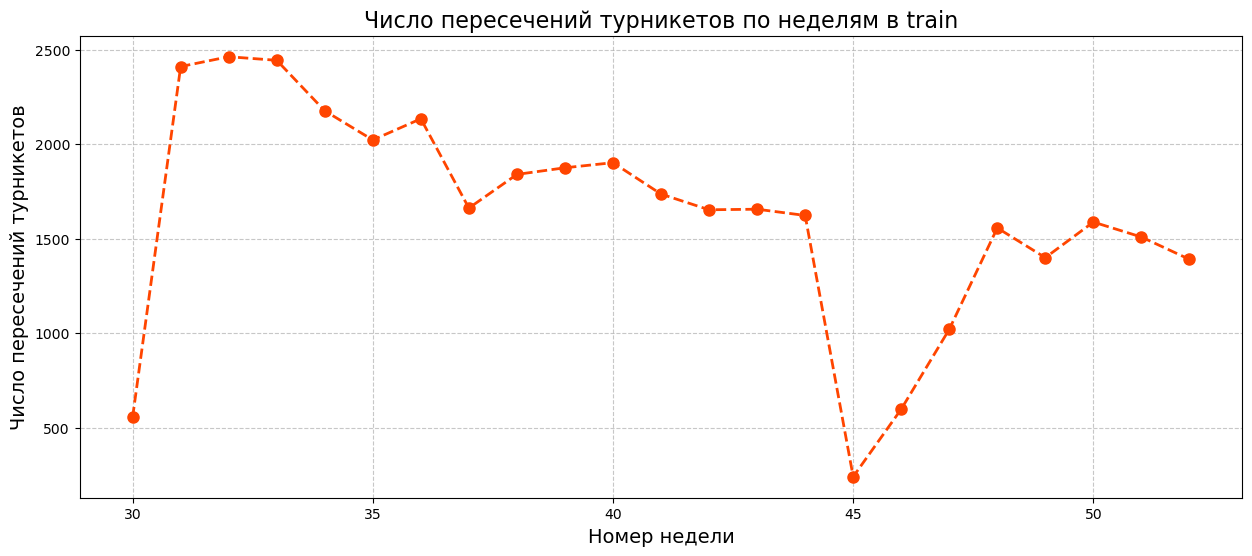

In [16]:
# Сортируем значения по номеру недели и строим график
plt.figure(figsize=(15, 6))
train['week_number'].value_counts().sort_index().plot(
    grid=True,
    color='orangered',
    linestyle='dashed', 
    marker='o',
    markersize=8, 
    linewidth=2  
)
plt.title('Число пересечений турникетов по неделям в train', fontsize=16)
plt.xlabel('Номер недели', fontsize=14)
plt.ylabel('Число пересечений турникетов', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)  
plt.show()

на 30, 45, 46, 47 неделе число проходов через турникет сильно меньше чем в остальные дни 

In [17]:
# функция для просмотра числа проходов по дням, показ начала и конец заданной недели
def show_week_number(week_count):
    print(f'-------------------------{week_count} неделя----------------------------------')
    print(train[train['week_number'] == week_count]['weekday'].value_counts().sort_index())
    print(f'Начало {week_count} недели: {train[train["week_number"] == week_count]["ts"].min()}')
    print(f'Конец {week_count} недели: {train[train["week_number"] == week_count]["ts"].max()}')
    
list_problem_week = [30, 45, 46, 47]
for i in list_problem_week:
    show_week_number(i)

-------------------------30 неделя----------------------------------
4    499
5     22
6     36
Name: weekday, dtype: int64
Начало 30 недели: 2022-07-29 09:08:54
Конец 30 недели: 2022-07-31 20:29:21
-------------------------45 неделя----------------------------------
0    178
4     42
6     22
Name: weekday, dtype: int64
Начало 45 недели: 2022-11-07 07:11:12
Конец 45 недели: 2022-11-13 23:28:42
-------------------------46 неделя----------------------------------
2     20
3    265
4    286
5     28
Name: weekday, dtype: int64
Начало 46 недели: 2022-11-16 15:04:59
Конец 46 недели: 2022-11-19 20:46:51
-------------------------47 неделя----------------------------------
0    262
1    257
2    251
3    240
6     11
Name: weekday, dtype: int64
Начало 47 недели: 2022-11-21 08:57:13
Конец 47 недели: 2022-11-27 15:33:21


In [18]:
# изменение типа данных
train = train.astype({'week_number': 'Int64'})

In [19]:
# удаление из данных 45 неделю
train = train[train['week_number'] != 45]

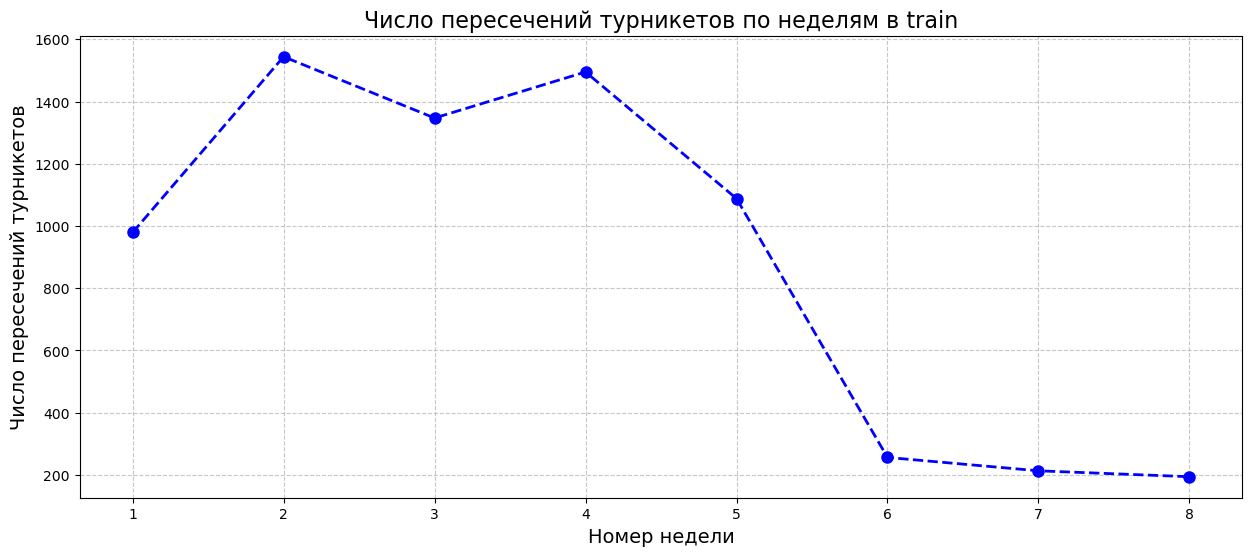

In [20]:
# Сортируем значения по номеру недели и строим график
plt.figure(figsize=(15, 6))
test['week_number'].value_counts().sort_index().plot(
    grid=True,
    color='blue',
    linestyle='dashed', 
    marker='o',
    markersize=8, 
    linewidth=2  
)
plt.title('Число пересечений турникетов по неделям в train', fontsize=16)
plt.xlabel('Номер недели', fontsize=14)
plt.ylabel('Число пересечений турникетов', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)  
plt.show()

количество посещений на 6, 7, 8 неделе на порядки ниже чем в предыдущие недели, такие данные будут вредны для модели машинного обучения

In [21]:
# удаление выбросов
test = test[~test['week_number'].isin([6, 7, 8])]

Так как признак week_number не пересекается в train и test, то удалим его, как и признак ts

In [22]:
# удаление признаков
train = train.drop(['ts', 'week_number'], axis = 1)
test = test.drop(['ts', 'week_number'], axis = 1)

In [23]:
# проверка и вывод недостающих hour
if sorted(list(train['hour'].unique())) != sorted(list(test['hour'].unique())):
    train_list = list(train['hour'].unique())
    test_list = list(test['hour'].unique())  
    print('Пропущенные hour', [x for x in train_list if x not in test_list] + [x for x in test_list if x not in train_list])
else:
    print('hour в train и test идентичны')

Пропущенные hour [6, 0, 1, 3]


Создадим признаки с учетом того, что у нас нет 6, 0, 1, 3 часа

In [24]:
# создание признаков 
night = [0, 1, 3, 22, 23]
morning = [6, 7, 8, 9, 10, 11]
time_day = [12, 13, 14, 15, 16, 17]
evening = [18, 19, 20, 21]
day_hours = [night, morning, time_day, evening]
day_hours_name = ['night', 'morning', 'time_day', 'evening']

for number, i in enumerate(day_hours):
    train[day_hours_name[number]] = train['hour'].apply(lambda row: 1 if row in i else 0)
    test[day_hours_name[number]] = test['hour'].apply(lambda row: 1 if row in i else 0)

In [25]:
# проверка и вывод недостающих day
if sorted(list(train['day'].unique())) != sorted(list(test['day'].unique())):
    train_list = list(train['day'].unique())
    test_list = list(test['day'].unique())  
    print('Пропущенные day', [x for x in train_list if x not in test_list] + [x for x in test_list if x not in train_list])
else:
    print('day в train и test идентичны')

Пропущенные day [8]


In [26]:
# создаем список уникальных значений дней
day_list = list(np.sort(train['day'].unique()))
day_list = [int(x) for x in day_list]

for i, day_value in enumerate(day_list):
    train[f'day_{i + 1}'] = train['day'].apply(lambda row: 1 if day_value == row else 0)
    test[f'day_{i + 1}'] = test['day'].apply(lambda row: 1 if day_value == row else 0)

In [27]:
# проверка и вывод недостающих weekday
if sorted(list(train['weekday'].unique())) != sorted(list(test['weekday'].unique())):
    train_list = list(train['weekday'].unique())
    test_list = list(test['weekday'].unique())  
    print('Пропущенные weekday', [x for x in train_list if x not in test_list] + [x for x in test_list if x not in train_list])
else:
    print('weekday в train и test идентичны')

weekday в train и test идентичны


In [28]:
# создаем новые признаки 
list_weekday = np.sort(train['weekday'].unique())
list_weekday = [int(x) for x in list_weekday]

for i, weekday_value in enumerate(list_weekday):
    train[f'weekday_{i}'] = train['weekday'].apply(lambda row: 1 if weekday_value == row else 0)
    test[f'weekday_{i}'] = test['weekday'].apply(lambda row: 1 if weekday_value == row else 0)

Ранее было выяснено что hour в train и test не совпадают, поэтому создадим единый список

In [29]:
# создание списка
list_hours_train = np.sort(train['hour'].unique())
list_hours_train = [int(x) for x in list_hours_train]
list_hours_test = np.sort(test['hour'].unique())
list_hours_test = [int(x) for x in list_hours_test]
common_list_hours = list(set(list_hours_train + list_hours_test))
common_list_hours = [int(x) for x in common_list_hours]
common_list_hours

[0, 1, 3, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]

In [30]:
# создание новых признаков 
for hour_value in common_list_hours:
    train[f'hour_{hour_value}'] = train['hour'].apply(lambda row: 1 if hour_value == row else 0)
    test[f'hour_{hour_value}'] = test['hour'].apply(lambda row: 1 if hour_value == row else 0)


In [31]:
# выведем уникальные значения gate_id из датасета train
gate_id_train = list(np.sort(train['gate_id'].unique()))
gate_id_test = list(np.sort(test['gate_id'].unique()))
common_gate_list = list(set(gate_id_train + gate_id_test))
common_gate_list = [int(x) for x in common_gate_list]

In [32]:
# создание новых признаков
for gate_value in common_gate_list:
    train[f'gate_id_{gate_value}'] = train['gate_id'].apply(lambda row: 1 if gate_value == row else 0)
    test[f'gate_id_{gate_value}'] = test['gate_id'].apply(lambda row: 1 if gate_value == row else 0)


На основе признака weekday создадим два бинарных признака: день может быть рабочим, день может быть выходным

In [33]:
# для каждого типа дня недели создадим соответствующий список
working_days = [0, 1, 2, 3, 4]
weekends = [5, 6]
week_days = [working_days, weekends]
week_days_name = ['working_days', 'weekends']

In [34]:
# создание новых признаков
number = 0
for weekdays_list in week_days:
    train[week_days_name[number]] = train['weekday'].apply(lambda row: 1 if row in weekdays_list else 0)
    test[week_days_name[number]] = test['weekday'].apply(lambda row: 1 if row in weekdays_list else 0)
    number += 1

In [35]:
# проверка и вывод недостающих minute
if sorted(list(train['minute'].unique())) != sorted(list(test['minute'].unique())):
    train_list = list(train['minute'].unique())
    test_list = list(test['minute'].unique())  
    print('Пропущенные weekday', [x for x in train_list if x not in test_list] + [x for x in test_list if x not in train_list])
else:
    print('minute в train и test идентичны')

minute в train и test идентичны


Сформируем 4 бинарных признака 

In [36]:
# для каждого периода создадим список значений минут
first_quarter = list(range(0, 15))
second_quarter = list(range(15, 30))
third_quarter = list(range(30, 45))
fourth_quarter = list(range(45, 60))
hour_minutes = [
    first_quarter, second_quarter,
    third_quarter, fourth_quarter
]
hour_minutes_names = [
    'first_quarter', 'second_quarter',
    'third_quarter', 'fourth_quarter'
]

In [37]:
# создание новых признаков
number = 0
for minutes_list in hour_minutes:
    train[hour_minutes_names[number]] = train['minute'].apply(lambda row: 1 if row in minutes_list else 0)
    test[hour_minutes_names[number]] = test['minute'].apply(lambda row: 1 if row in minutes_list else 0)
    number += 1

Проверим есть ли в данных нулевые признаки (признаки полностью заполненные 0)

In [38]:
# проверка на нулевой вектор в train
temp_train = pd.DataFrame(train.sum(), columns = ['sum_total'])
temp_train.loc[temp_train['sum_total'] == 0]

,sum_total
hour_0,0
hour_1,0
hour_3,0


In [39]:
# проверка на нулевой вектор в test
temp_test = pd.DataFrame(test.sum(), columns = ['sum_total'])
temp_test.loc[temp_test['sum_total'] == 0]

,sum_total
day_8,0
hour_6,0


In [40]:
# создадим список из названий признаков на удаление
columns_to_del = (
    list(temp_train.loc[temp_train['sum_total'] == 0].index) +
    list(temp_test.loc[temp_test['sum_total'] == 0].index)
)
columns_to_del

['hour_0', 'hour_1', 'hour_3', 'day_8', 'hour_6']

In [41]:
# удаление нулевых векторов
train = train.drop(columns_to_del, axis = 1)
test = test.drop(columns_to_del, axis = 1)

Напишем код, который указывает на мультиколинеарность признаков, порог будем считать 0.75 и -0.75

In [42]:
# выявление признаков
correlation_matrix = train.corr()
threshold = 0.8
correlation_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            feature_pair = (correlation_matrix.columns[i], correlation_matrix.columns[j])
            correlation_value = correlation_matrix.iloc[i, j]
            correlation_pairs.append((feature_pair, correlation_value))

for pair, correlation_value in correlation_pairs:
    print(f"Пара признаков: {pair}, Корреляция: {correlation_value}")

Пара признаков: ('night', 'hour_22'), Корреляция: 0.8888494373250212
Пара признаков: ('weekday_5', 'working_days'), Корреляция: -0.842200156573852
Пара признаков: ('weekday_5', 'weekends'), Корреляция: 0.8422001565738518
Пара признаков: ('working_days', 'weekends'), Корреляция: -1.0000000000000002


In [43]:
# удалим признаки создающие мультиколинеарность
train = train.drop(columns = ['hour_22', 'weekday_5', 'weekends'], axis = 1)
test = test.drop(columns = ['hour_22', 'weekday_5', 'weekends'], axis = 1)

Выделим features и target

In [44]:
# выделение features и target
features_train = train.drop(columns = 'user_id')
target_train = train['user_id']
features_train.shape, target_train.shape

((37216, 79), (37216,))

In [45]:
# выделение user_word и features
user_word = test['user_word']
features_test = test.drop(columns = 'user_word')
features_test.shape, user_word.shape

((6453, 79), (6453,))

In [48]:
# создаем коппи датасетов
features_train_ovr = features_train.copy()
features_test_ovr = features_test.copy()
features_train_ovr.shape, features_test_ovr.shape

((37216, 79), (6453, 79))

In [49]:
# применим MinMaxScaler()
scaler_ovr = MinMaxScaler()
scaler_ovr.fit(features_train_ovr)
features_train_ovr = scaler_ovr.transform(features_train_ovr)
features_test_ovr = scaler_ovr.transform(features_test_ovr)
features_test_ovr = scaler_ovr.transform(features_test_ovr)

C:\Users\kil_a\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [53]:
# инициализация модели
lm = OneVsRestClassifier(
    LogisticRegression(
        multi_class='ovr',
        solver='lbfgs',
        max_iter = 1000, 
        random_state = 12345))

In [55]:
# обучим модель
lm.fit(features_train_ovr, target_train)

OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000,
                                                 multi_class='ovr',
                                                 random_state=12345))

In [57]:
# получим предсказания
preds_train_lm = lm.predict(features_train_ovr)

In [59]:
# выведем отчет об итогах обучения
print(classification_report(
    target_train,
    preds_train_lm
))

              precision    recall  f1-score   support

           0       0.07      0.02      0.03      1244
           1       0.22      0.29      0.25      1288
           2       0.21      0.10      0.14        39
           3       0.18      0.35      0.23       989
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00        10
           6       0.16      0.07      0.09      1990
           7       0.33      0.45      0.38        49
           8       0.41      0.31      0.35        29
           9       0.12      0.13      0.13      1034
          10       0.17      0.12      0.14        17
          11       0.10      0.10      0.10      1279
          12       0.15      0.32      0.20      1937
          14       0.25      0.46      0.32       685
          15       0.18      0.19      0.18      1701
          17       0.25      0.35      0.29       661
          18       0.35      0.29      0.32      1566
          19       0.19    

C:\Users\kil_a\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kil_a\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kil_a\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [61]:
# получим предсказания модели на тестовых обучающих признаках
preds = lm.predict(features_test_ovr)

In [63]:
# объединим зашифрованные имена посетителей и предсказания модели
submit = pd.DataFrame()

submit['user_word'] = user_word
submit['preds'] = preds

In [67]:
# частота встречаемости user_word
user_word_frequency = pd.DataFrame(
    data = submit['user_word'].value_counts(ascending = False)
)
user_word_frequency.columns = ['quantity']
user_word_frequency

,quantity
f1,694
loss,484
sigmoid,400
binary,355
epsilon,334
x,294
significant,281
collinear,273
independent,259
residual,228


In [77]:
# список с 50 и менее наблюдениями
less_than_51 = [
    user_word_frequency.index.values[i]
    for i in range(len(user_word_frequency['quantity']))
    if user_word_frequency['quantity'][i] < 51
]
less_than_51.sort()
less_than_51

['aucroc', 'blue', 'lasso', 'logistic', 'precision', 'regression', 'y']

In [78]:
# предсказанные уникальные user_id
submit['preds'].unique()

array([ 3, 15,  1, 34, 31,  0, 12,  8, 50, 42, 18,  9, 40, 54, 33, 20, 11,
       53, 49,  6, 48, 28, 55, 27, 47, 46, 25, 37, 29, 57, 22, 19, 32, 39,
       24, 26], dtype=int64)

In [79]:
# выведем количество уникальных user_id,
# содержащихся в предсказании модели
submit['preds'].nunique()

36

Скорей всего система ошиблась в детекции посетителя, поэтому для каждого user_id c меньше 50 наблюдениями preds: -999

In [80]:
# итоговые предсказания получим на основе самого частотного 'user_id'
submit_file = pd.DataFrame(
    submit.groupby('user_word')['preds'].agg(
        lambda x: x.value_counts().index[0])
    )

In [81]:
# заменяем на -999 
submit_file['new_preds'] = [
    -999 if submit_file.index.values[i] in less_than_51
    else submit_file['preds'][i]
    for i in range(len(submit_file['preds']))
]

In [82]:
# удаление столбца preds и меняем название столбца 
submit_file = submit_file.drop(columns = ['preds'])
submit_file.columns = ['preds']
submit_file

,preds
user_word,
aucroc,-999
binary,12
blue,-999
categorical,15
coefficient,3
collinear,15
distributed,34
epsilon,15
f1,18


In [83]:
#количество уникальных user_id в submit_file
submit_file['preds'].nunique()

6

In [84]:
submit_file.to_csv('answer.csv')

In [85]:
code = """
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
"""

file_path = 'requirements.txt'

with open(file_path, 'w') as file:
    file.write(code)

In [87]:
# теперь попробуем CatBoost
catboost = CatBoostClassifier(
    random_state = 12345,
    logging_level = 'Silent',
    loss_function = 'MultiClassOneVsAll'
)

In [92]:
# инициализация пайплайна
pipe_catboost = imb_pipeline([
    ('feature_select', SelectKBest(score_func = chi2)),
    ('catboost', catboost)
])

In [93]:
# список гиперпараметров пайплайна
pd.DataFrame(pipe_catboost.get_params().keys())

,0
0,memory
1,steps
2,verbose
3,feature_select
4,catboost
5,feature_select__k
6,feature_select__score_func
7,catboost__loss_function
8,catboost__logging_level
9,catboost__random_state


In [168]:
# словарь с гиперпараметрами
params_catboost = {
    'feature_select__k': [40, 50, 60, 70, 80],
#     'catboost__iterations': [300, 500],
#     'catboost__learning_rate': [0.01, 0.03, 0.05, 0.1],
#     'catboost__depth': [2, 4, 6],
#     'catboost__l2_leaf_reg': [1, 3, 5]
}

In [169]:
# объявляем объект RandomizedSearchCV
grid_catboost = GridSearchCV(
    pipe_catboost,
    params_catboost,
#     n_iter = 10,
    scoring = 'roc_auc',
    verbose = 1,
    cv = 3,
    refit = True,
    n_jobs = -1)

In [170]:
%%time
# обучение модели
grid_catboost.fit(features_train, target_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


C:\Users\kil_a\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
C:\Users\kil_a\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
3 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\kil_a\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\kil_a\anaconda3\lib\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y

CPU times: total: 12min 58s
Wall time: 10min 14s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('feature_select',
                                        SelectKBest(score_func=<function chi2 at 0x0000022032E1A200>)),
                                       ('catboost',
                                        <catboost.core.CatBoostClassifier object at 0x0000022032D1AEC0>)]),
             n_jobs=-1, param_grid={'feature_select__k': [40, 50, 60, 70, 80]},
             scoring='roc_auc', verbose=1)

In [171]:
# сохранение лучшей модели
best_catboost = grid_catboost.best_estimator_
print(f'Гиперпараметры лучшей модели: {grid_catboost.best_params_}')

Гиперпараметры лучшей модели: {'feature_select__k': 40}


In [172]:
# получим предсказания
preds_train = best_catboost.predict(features_train)

In [173]:
# отчет об итогах обучения
print(classification_report(
    target_train,
    preds_train
))

              precision    recall  f1-score   support

           0       0.44      0.26      0.32      1244
           1       0.45      0.42      0.44      1288
           2       0.49      0.69      0.57        39
           3       0.45      0.58      0.51       989
           4       1.00      1.00      1.00         2
           5       0.44      0.40      0.42        10
           6       0.44      0.28      0.34      1990
           7       0.69      0.76      0.72        49
           8       0.53      0.93      0.67        29
           9       0.30      0.42      0.35      1034
          10       0.44      0.41      0.42        17
          11       0.30      0.27      0.28      1279
          12       0.33      0.55      0.42      1937
          14       0.45      0.76      0.57       685
          15       0.37      0.51      0.43      1701
          17       0.53      0.72      0.61       661
          18       0.57      0.49      0.53      1566
          19       0.45    

In [174]:
# предсказания на test
preds = best_catboost.predict(features_test)

In [175]:
# объединим зашифрованные имена посетителей и предсказания модели
submit = pd.DataFrame()

submit['user_word'] = user_word
submit['preds'] = preds

In [176]:
# уникальные предсказанные user_id
print(f'Уникальные user_id: {np.sort(submit.preds.unique())}')
print(f'Количество предсказанных уникальных user_id: {submit.preds.nunique()}')

Уникальные user_id: [ 0  1  3  6  9 11 12 14 15 17 19 23 24 25 26 29 30 32 33 35 37 39 41 43
 46 49 50 54 55]
Количество предсказанных уникальных user_id: 29


In [177]:
# итоговое предсказание получим на основе чаще предсказанного user_id
submit_file = pd.DataFrame(
    submit.groupby('user_word')['preds'].agg(
        lambda x: x.value_counts().index[0])
    )

In [178]:
# предсказания 
submit_file

,preds
user_word,
aucroc,55
binary,12
blue,55
categorical,14
coefficient,15
collinear,55
distributed,55
epsilon,1
f1,6


In [179]:
# количество уникальных user_id в submit_file
submit_file['preds'].nunique()

14

In [180]:
submit_file.to_csv('answer.csv')

In [181]:
code = """
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_regression, chi2
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline as imb_pipeline
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
"""

file_path = 'requirements.txt'

with open(file_path, 'w') as file:
    file.write(code)

In [126]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37216 entries, 0 to 37517
Data columns (total 79 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Unnamed: 0      37216 non-null  int64
 1   gate_id         37216 non-null  int64
 2   day             37216 non-null  int64
 3   weekday         37216 non-null  int64
 4   hour            37216 non-null  int64
 5   minute          37216 non-null  int64
 6   night           37216 non-null  int64
 7   morning         37216 non-null  int64
 8   time_day        37216 non-null  int64
 9   evening         37216 non-null  int64
 10  day_1           37216 non-null  int64
 11  day_2           37216 non-null  int64
 12  day_3           37216 non-null  int64
 13  day_4           37216 non-null  int64
 14  day_5           37216 non-null  int64
 15  day_6           37216 non-null  int64
 16  day_7           37216 non-null  int64
 17  day_9           37216 non-null  int64
 18  day_10          37216 non-